In [1]:
import pandas as pd

#Carrega os dados

x = pd.read_csv("data/dengue_features_train.csv")
y = pd.read_csv("data/dengue_labels_train.csv")

data = x.merge(y, on=("city", "year", "weekofyear"))
data = data.drop(labels=["week_start_date"], axis=1) #coluna irrelevante, por isso tirei

data_sj = data[data.city=="sj"].sort_values(by=["year", "weekofyear"])
data_sj = data_sj.drop(labels=["city"], axis=1)
x_sj = data_sj.values[:,:-1]
y_sj = data_sj.values[:,-1]

data_iq = data[data.city=="iq"].sort_values(by=["year", "weekofyear"])
data_iq = data_iq.drop(labels=["city"], axis=1)
x_iq = data_iq.values[:,:-1]
y_iq = data_iq.values[:,-1]

In [2]:
import numpy as np
from copy import deepcopy

#coloca valores nos campos que nao possuem nenhum valor

def input_missing_values(x_array):
    _x_array = deepcopy(x_array)
    size = len(_x_array)
    for i, x in enumerate(_x_array):
        for j, f_value in enumerate(x):
            if np.isnan(f_value):
                i_before = i
                i_after = i
                while np.isnan(_x_array[i_before, j]):
                    i_before -= 1
                    if i_before == -1:
                        break
                while np.isnan(_x_array[i_after, j]):
                    i_after += 1
                    if i_after == size:
                        break
                if i_before == -1 and i_after != size:
                    _x_array[i,j] = _x_array[i_after,j]
                elif i_before != -1 and i_after == size:
                    _x_array[i,j] = _x_array[i_before,j]
                elif i_before != -1:
                    _x_array[i,j] = (_x_array[i_before,j] + _x_array[i_after,j])/2
                else:
                    print("Nao ha valores para inputar na coluna de numero %d"%j)
                    return None
    return _x_array

def check_nan(x_array):
    total_nan = 0
    for i, x in enumerate(x_array):
        for j, f_value in enumerate(x):
            if np.isnan(f_value):
                total_nan += 1
    return total_nan

print(check_nan(x_sj))
x_sj = input_missing_values(x_sj)
print(check_nan(x_sj))

380
0


In [3]:
from sklearn.preprocessing import StandardScaler

#scaler para colocar os valores na mesma escala
scaler = StandardScaler()
x_sj_std = scaler.fit_transform(x_sj)

In [4]:
#separa o dataset em treino e teste
train_size = int(4*len(x_sj_std)/5)
x_train_sj_std = x_sj_std[:train_size,:]
x_test_sj_std = x_sj_std[train_size:,:]
y_train_sj = y_sj[:train_size]
y_test_sj = y_sj[train_size:]

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

#regressao linear

def accuracy(model, x, y_true):
    y_pred = model.predict(x)
    return(mean_absolute_error(y_true, y_pred))

lr = LinearRegression(normalize=False)
lr.fit(x_train_sj_std, y_train_sj)
print("Erro Absoluto Medio - Treino: %f"%accuracy(lr, x_train_sj_std, y_train_sj))
print("Erro Absoluto Medio - Teste: %f"%accuracy(lr, x_test_sj_std, y_test_sj))

Erro Absoluto Medio - Treino: 28.006939
Erro Absoluto Medio - Teste: 23.349801


In [6]:
from sklearn.ensemble import RandomForestRegressor

#regressao com Random Forest

rfr = RandomForestRegressor(random_state=1, max_features="auto", max_depth=8)
rfr.fit(x_train_sj_std, y_train_sj)
print("Erro Absoluto Medio - Treino: %f"%accuracy(rfr, x_train_sj_std, y_train_sj))
print("Erro Absoluto Medio - Teste: %f"%accuracy(rfr, x_test_sj_std, y_test_sj))

importances = rfr.feature_importances_
indices = np.argsort(importances)[::-1]
print()
print("Relevancia de cada variavel para o regressor:")
for f in range(x_train_sj_std.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, data_sj.columns[:-1][indices[f]], importances[indices[f]]))

Erro Absoluto Medio - Treino: 9.883844
Erro Absoluto Medio - Teste: 16.947596

Relevancia de cada variavel para o regressor:
 1) weekofyear                     0.181369
 2) year                           0.168649
 3) ndvi_se                        0.120387
 4) ndvi_ne                        0.111223
 5) ndvi_sw                        0.094164
 6) ndvi_nw                        0.075466
 7) station_max_temp_c             0.045191
 8) reanalysis_dew_point_temp_k    0.034218
 9) reanalysis_specific_humidity_g_per_kg 0.031170
10) reanalysis_max_air_temp_k      0.021070
11) station_diur_temp_rng_c        0.020774
12) station_min_temp_c             0.020338
13) station_precip_mm              0.017131
14) reanalysis_tdtr_k              0.015251
15) station_avg_temp_c             0.011023
16) reanalysis_avg_temp_k          0.008201
17) reanalysis_precip_amt_kg_per_m2 0.006351
18) precipitation_amt_mm           0.004901
19) reanalysis_air_temp_k          0.003917
20) reanalysis_relative_humidit

In [ ]:
from sklearn.model_selection import GridSearchCV

#tenta achar os melhores parametros para o Random Forest (acho que nao funcionou)
rfr = RandomForestRegressor()
param_grid_rfr = {
    "max_depth":[n for n in range(1,30)],
    "max_features":[n for n in range(1,23)]
}
CV_rfr = GridSearchCV(estimator = rfr, param_grid=param_grid_rfr, cv=5,n_jobs=-1)
CV_rfr.fit(x_sj_std, y_sj)
print(CV_rfr.best_params_)
CV_rfr.best_score_

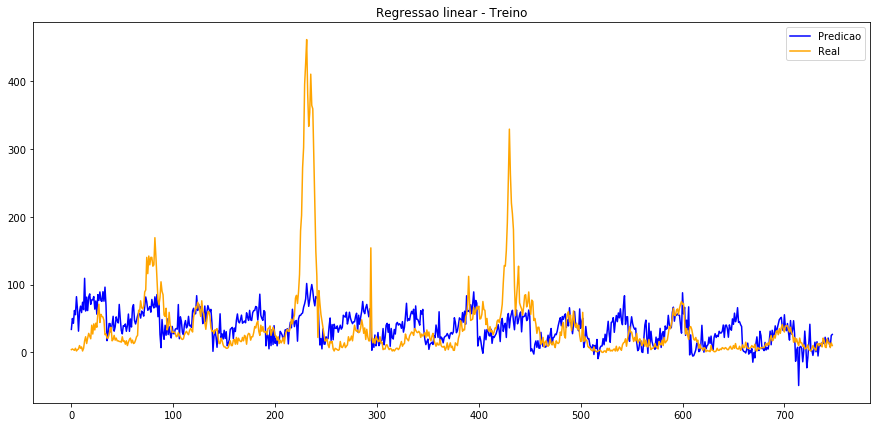

Mean absolute error: 28.006939


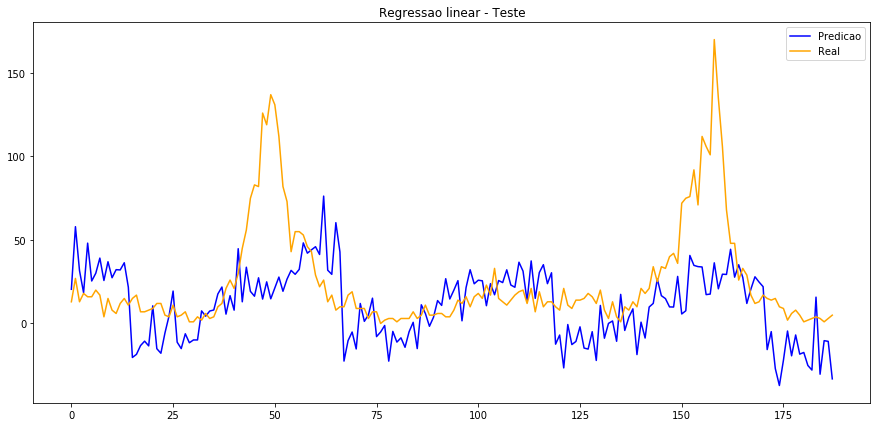

Mean absolute error: 23.349801


In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

#regressao linear 2.0 com graficos

lr = LinearRegression(normalize=False, fit_intercept=True)
lr.fit(x_train_sj_std, y_train_sj)

y_pred = lr.predict(x_train_sj_std)

plt.figure(figsize=(15,7))
plt.plot([i for i in range(0,len(y_pred))], y_pred, color="blue", label="Predicao")
plt.plot([i for i in range(0,len(y_pred))], y_train_sj, color="orange", label="Real")
plt.legend()
plt.title("Regressao linear - Treino")
plt.show()
print("Mean absolute error: %f"%mean_absolute_error(y_train_sj, y_pred))

y_pred = lr.predict(x_test_sj_std)

plt.figure(figsize=(15,7))
plt.plot([i for i in range(0,len(y_pred))], y_pred, color="blue", label="Predicao")
plt.plot([i for i in range(0,len(y_pred))], y_test_sj, color="orange", label="Real")
plt.legend()
plt.title("Regressao linear - Teste")
plt.show()
print("Mean absolute error: %f"%mean_absolute_error(y_test_sj, y_pred))

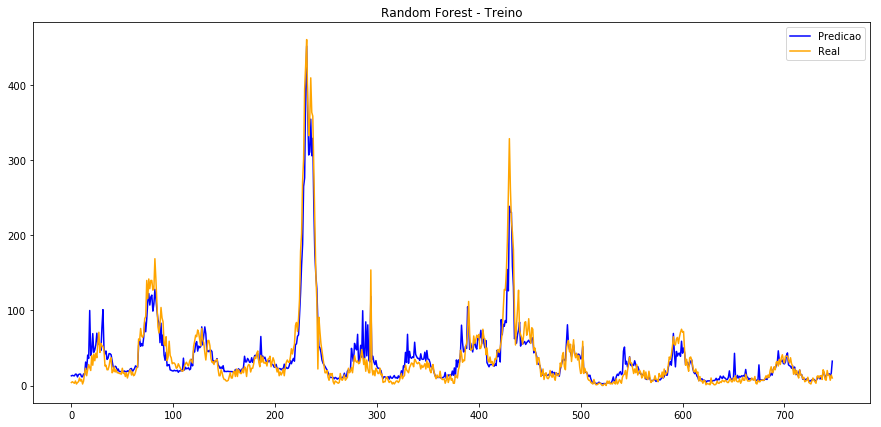

Mean absolute error: 9.883844


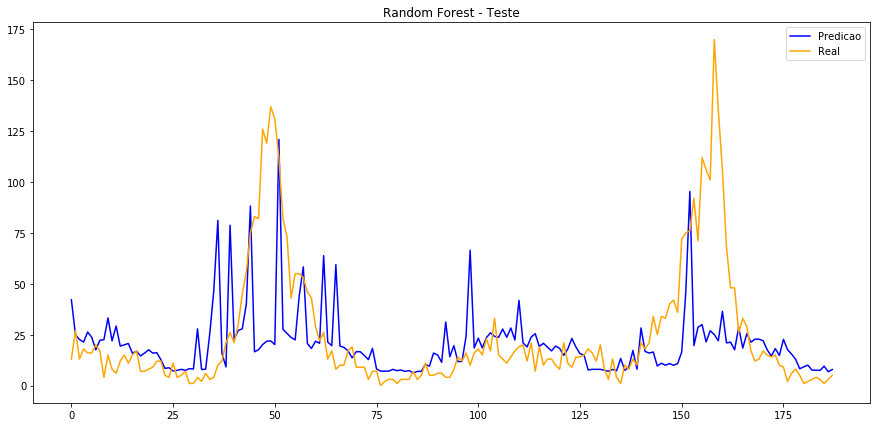

Mean absolute error: 16.947596


In [9]:
#Random Forest com graficos (muito overfitting!)

rfr = RandomForestRegressor(random_state=1, max_features="auto", max_depth=8)
rfr.fit(x_train_sj_std, y_train_sj)

y_pred = rfr.predict(x_train_sj_std)

plt.figure(figsize=(15,7))
plt.plot([i for i in range(0,len(y_pred))], y_pred, color="blue", label="Predicao")
plt.plot([i for i in range(0,len(y_pred))], y_train_sj, color="orange", label="Real")
plt.legend()
plt.title("Random Forest - Treino")
plt.show()
print("Mean absolute error: %f"%mean_absolute_error(y_train_sj, y_pred))

y_pred = rfr.predict(x_test_sj_std)

plt.figure(figsize=(15,7))
plt.plot([i for i in range(0,len(y_pred))], y_pred, color="blue", label="Predicao")
plt.plot([i for i in range(0,len(y_pred))], y_test_sj, color="orange", label="Real")
plt.legend()
plt.title("Random Forest - Teste")
plt.show()
print("Mean absolute error: %f"%mean_absolute_error(y_test_sj, y_pred))